##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

import nltk

Import `matplotlib` and create a helper function to plot graphs:

In [285]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset = pd.read_csv('./dataset.csv', sep=';')
dataset.head()

,question,intent
0,Como usar lucros e reinvestir sem ser esmagado...,instruction
1,Como fazer boas escolhas de ações se 'resultad...,instruction
2,O que é Compra a Seco?,definition
3,Que eventos mais afetam os preços das ações?,explanation
4,Quais são os melhores recursos para aprender s...,instruction


In [ ]:
# Remember to One-Hot-Encode the dataset intents here

##One-Hot-Encoding


In [ ]:
intent_to_int = {
    'explanation': 0,
    'instruction': 1,
    'comparison': 2,
    'definition': 3
}
integer_intents = dataset['intent'].apply(lambda intent: intent_to_int[intent])
integer_intents.head()

0    1
1    1
2    3
3    0
4    1
Name: intent, dtype: int64

##First steps
Preprocessing

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We first tokenize strings

In [ ]:
forbidden_character_set = set(list('.?!;\','))
no_punctuation_strings = dataset['question'].apply(lambda sentence: ''.join(filter(lambda c: c not in forbidden_character_set, sentence)))
no_punctuation_strings.head()

0    Como usar lucros e reinvestir sem ser esmagado...
1    Como fazer boas escolhas de ações se resultado...
2                                O que é Compra a Seco
3          Que eventos mais afetam os preços das ações
4    Quais são os melhores recursos para aprender s...
Name: question, dtype: object

In [ ]:
tokenized_strings = no_punctuation_strings.apply(lambda sentence: word_tokenize(sentence.lower()))
tokenized_strings.head()

0    [como, usar, lucros, e, reinvestir, sem, ser, ...
1    [como, fazer, boas, escolhas, de, ações, se, r...
2                         [o, que, é, compra, a, seco]
3    [que, eventos, mais, afetam, os, preços, das, ...
4    [quais, são, os, melhores, recursos, para, apr...
Name: question, dtype: object

In [ ]:
tokenized_strings.head()

0    [como, usar, lucros, e, reinvestir, sem, ser, ...
1    [como, fazer, boas, escolhas, de, ações, se, r...
2                         [o, que, é, compra, a, seco]
3    [que, eventos, mais, afetam, os, preços, das, ...
4    [quais, são, os, melhores, recursos, para, apr...
Name: question, dtype: object

Stemming of words

In [262]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [263]:
stemmer = nltk.stem.RSLPStemmer()

In [264]:
stemmed_tokens = tokenized_strings.apply(lambda row: [stemmer.stem(word) for word in row])
stemmed_tokens.head()

0    [com, us, lucr, e, reinvest, sem, ser, esmag, ...
1    [com, faz, boa, escolh, de, açõ, se, result, p...
2                           [o, que, é, compr, a, sec]
3          [que, event, mais, afet, os, preç, da, açõ]
4    [qual, são, os, melhor, recurs, par, aprend, s...
Name: question, dtype: object

##One-Hot-Encoding

In [265]:
integer_intents.head()

0    1
1    1
2    3
3    0
4    1
Name: intent, dtype: int64

In [266]:
ohe_intents = tf.keras.utils.to_categorical(integer_intents)
ohe_intents[:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [267]:
stringified_tokens = stemmed_tokens.apply(lambda tokens: ' '.join(tokens))
stringified_tokens.head()

0      com us lucr e reinvest sem ser esmag por impost
1    com faz boa escolh de açõ se result pass não s...
2                                  o que é compr a sec
3                   que event mais afet os preç da açõ
4    qual são os melhor recurs par aprend sobr inve...
Name: question, dtype: object

In [268]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(stringified_tokens, ohe_intents, shuffle=True, random_state=random_state)

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [269]:
VOCAB = {word for words in stemmed_tokens for word in words}
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=len(VOCAB))
encoder.adapt(stringified_tokens.to_numpy())

)The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [270]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'o', 'que', 'de', 'invest', 'qual', 'é', 'são',
       'rend', 'fund', 'par', 'melhor', 'os', 'em', 'quant', 'por', 'a',
       'não', 'dinh'], dtype='<U10')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [271]:
encoded_example = encoder(X_train)
encoded_example[:5]

<tf.Tensor: shape=(5, 28), dtype=int64, numpy=
array([[  6,   7,   2,  12,   5,  11,  30,  79, 101,  19,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,  12,  29,  60,  36,  40, 125,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  6,   8,  13,  12,  93,  11, 154,  82,   5,  14,  76,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2,   3,   7,  31,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,  53,  11,   4,  47,  23,  44,   4,   9,   5,  94, 166, 113,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [272]:
for n in range(3):
  print("Original: ", X_train.iloc[n])
  print("Round-trip: ", " ".join(map(lambda x: vocab[x], encoded_example[n]))
)
  print()

Original:  qual é o melhor invest par qu tem pouc dinh
Round-trip:  qual é o melhor invest par qu tem pouc dinh                  

Original:  é melhor us etf ou açõ individ
Round-trip:  é melhor us etf ou açõ individ                     

Original:  qual são os melhor recurs par aprend sobr invest em títul
Round-trip:  qual são os melhor recurs par aprend sobr invest em títul                 



## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [273]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [274]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [275]:
sample_text = ('Quero ficar rico')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.50082886 0.4973201  0.49925438 0.5022941 ]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [231]:
padding = "O " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.25239682 0.25034732 0.24958292 0.24767295]


Compile the Keras model to configure the training process:

In [276]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [277]:
history = model.fit(X_train, y_train, epochs=160,
                    validation_data=(X_test, y_test))

Epoch 1/160
2/2 [==============================] - 8s 2s/step - loss: 1.3864 - accuracy: 0.1860 - val_loss: 1.3855 - val_accuracy: 0.2000
Epoch 2/160
2/2 [==============================] - 0s 32ms/step - loss: 1.3851 - accuracy: 0.2326 - val_loss: 1.3848 - val_accuracy: 0.2667
Epoch 3/160
2/2 [==============================] - 0s 30ms/step - loss: 1.3842 - accuracy: 0.3023 - val_loss: 1.3841 - val_accuracy: 0.2667
Epoch 4/160
2/2 [==============================] - 0s 29ms/step - loss: 1.3833 - accuracy: 0.3721 - val_loss: 1.3834 - val_accuracy: 0.4000
Epoch 5/160
2/2 [==============================] - 0s 37ms/step - loss: 1.3824 - accuracy: 0.4186 - val_loss: 1.3827 - val_accuracy: 0.4000
Epoch 6/160
2/2 [==============================] - 0s 31ms/step - loss: 1.3816 - accuracy: 0.4419 - val_loss: 1.3820 - val_accuracy: 0.4000
Epoch 7/160
2/2 [==============================] - 0s 31ms/step - loss: 1.3808 - accuracy: 0.4419 - val_loss: 1.3813 - val_accuracy: 0.4667
Epoch 8/160
2/2 [=====

In [278]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 19ms/step - loss: 0.6551 - accuracy: 0.8000
Test Loss: 0.6551097631454468
Test Accuracy: 0.800000011920929


(0.0, 1.4412686556577683)

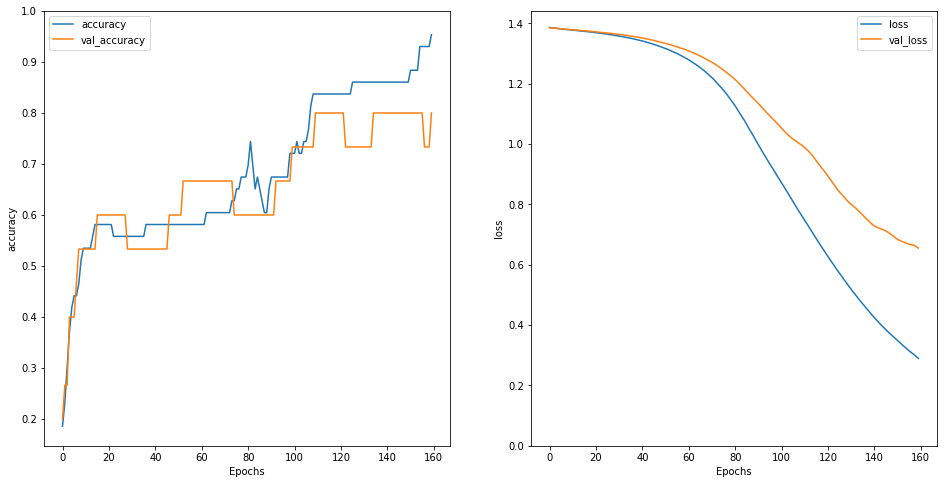

In [286]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [284]:
sample_text = ('Pode me dizer o que é fundo de investimento?')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.8891605, 0.0034244, 0.0400797, 0.9428744]], dtype=float32)